Load Data

In [1]:
# Load data and preprocess accordingly

Write Predictor

In [1]:
import torch
from collections import deque

class Predictor:
  def __init__(self, predictor, window_size=84, prediction_size=3):
    self.predictor = predictor
    self.window_size = window_size
    self.prediction_size = prediction_size
    self.window = deque()
    self.is_updated = True
    self.last_predicted = []
    self.pred_idx = prediction_size

  def predict(self):
    if not self.is_updated:
      self._insert(self.last_predicted[self.pred_idx - 1])
    
    if self.pred_idx >= self.prediction_size:
      # Get prediction window
      extracted_values = self._get_window()
      first_value = extracted_values[0] if len(extracted_values) > 0 else 0
      
      # Add padding if needed
      padding = [first_value] * (self.window_size - len(extracted_values))
      padding.extend(extracted_values)

      # Prepare input tensor
      input_tensor = torch.tensor(padding, dtype=torch.float32).reshape(1, -1)

      self.last_predicted = self.predictor(input_tensor).squeeze(0).detach().numpy().tolist()

      # Reset index
      self.pred_idx = 0

    self.is_updated = False
    self.pred_idx += 1
    return self.last_predicted[self.pred_idx - 1]
    
    '''
    Include one of the three following functions,
      - reset
      - update_from_model_params_approx
      - update_from_model_params_exact
    '''

  def _insert(self, value):
    # If the window is full, pop the element from the back
    if len(self.window) >= self.window_size:
      self.window.popleft()
    # Insert the new element at the front
    self.window.append(value)

  def _get_window(self):
    return list(self.window)

  def __reset(self, value):
    self._insert(value)
    self.is_updated = True
    # Reset memory element
    ""

  def __update_from_model_params_approx(self, value, params_approximate):
    # Reset memory elements based on a approximate / quantized model parameters
    ""

  def __update_from_model_params_exact(self, value, params_exact):
    # Reset memory elements based on precise model parameters
    ""

  def get_params_approx(self):
    # Return approximate model parameters
    ""

  def get_params_exact(self):
    # Return precise model parameters
    ""

  def update_from_residual(self, residual):
    self._insert(self.last_predicted[self.pred_idx - 1] + residual)
    self.is_updated = True
    ""

  def update_from_data(self, value, params=None, partial_complete=None):
    '''
      use one of the three functions,
    '''
    if params is not None:
      if partial_complete == 'p':
        self.__update_from_model_params_approx(value, params)
      elif partial_complete == 'c':
        self.__update_from_model_params_exact(value, params)
      else:
        raise Exception("parameter types are not specified")
    else:
      self.__reset(value)

    # Update memory elements based on complete data

ModuleNotFoundError: No module named 'torch'

Dataframe structure

In [3]:
class DataFrame:
  def __init__(self, seq_number:int, timestamp, comp_resid_flag:bool, value:float, params=None):
    self.seq_number = seq_number
    self.timestamp = timestamp
    self.comp_resid_flag = comp_resid_flag  # True if it's a complete datapoint, False if it's a residual
    self.value = value
    self.params = params

  def __str__(self):
    return f"{self.seq_number}|{self.timestamp}|{self.comp_resid_flag}|{self.value}|{self.params}"


Encoder

In [4]:
import pandas as pd
from typing import List
import random
from tqdm.notebook import tqdm

'''
Dataframe needs to have a 'timestamp' column of when the data was recorded
'''

class Encoder:
  def __init__(self, predictor:Predictor):
    self.predictor = predictor

  def encode(self, data:pd.DataFrame, data_column:str, threshold:float, residual_complete_switch_probability=0.01):
    encoded_list = []
    sequence_number = 0
    for index, row in tqdm(data.iterrows(), desc="Encoding: ", total=len(data)):
      if random.random() < residual_complete_switch_probability:
        # Get model params (if updating from params is set up)
        # params = self.predictor.get_params_approx()
        # params = self.predictor.get_params_exact()

        # Append full value
        encoded_list.append(DataFrame(sequence_number, row['timestamp'], True, row[data_column]))
        # encoded_list.append(DataFrame(sequence_number, row['timestamp'], True, row[data_column], params=params))

        # Reset model
        self.predictor.update_from_data(row[data_column])
        # self.predictor.update_from_data(row[data_column], params=params)

      else:
        # Predict next value
        predicted_val = self.predictor.predict()

        # Generate residual (calculate error)
        error = row[data_column] - predicted_val

        # Record only if the error is above threshold
        if abs(error / (row[data_column] + 1e-8)) > threshold:
          encoded_list.append(DataFrame(sequence_number, row['timestamp'], False, error))
          self.predictor.update_from_residual(error)

      # Increment sequence number
      sequence_number += 1
    return encoded_list


Decoder

In [5]:
from typing import List

class Decoder:
  def __init__(self, predictor:Predictor):
    self.predictor = predictor

  def __get_sequence_percentage(self, i, last_sequence_number:int, sequence_number:int):
    return (i - last_sequence_number) / (sequence_number - last_sequence_number)

  def __interpolate_time(self, sequence_percentage, last_timestamp, data_timestamp):
    return last_timestamp * (1 - sequence_percentage) + data_timestamp * sequence_percentage

  def decode(self, encoded_list:List[DataFrame]):
    decoded_list = []

    # Store previous dataframe's data
    last_sequence_number = -1
    last_timestamp = None

    # For each dataframe
    for data in tqdm(encoded_list, desc="Decoding: "):
      # For each skipped sequence
      for i in range(last_sequence_number + 1, data.seq_number + 1):
        if last_timestamp is None:
          last_timestamp = data.timestamp
        else:
          # Reconstruct time through interpolation
          sequence_percentage = self.__get_sequence_percentage(i, last_sequence_number, data.seq_number)
          interpolated_time = self.__interpolate_time(sequence_percentage, last_timestamp, data.timestamp)

          # Generate datapoint
          predicted_point = self.predictor.predict()
          decoded_list.append((interpolated_time, predicted_point))

      # Correct last prediction
      if data.comp_resid_flag:
        self.predictor.update_from_data(data.value)  # Add parameters and specify type if applicable

        # Update based on complete value
        decoded_list[-1] = (data.timestamp, data.value)
      else:
        self.predictor.update_from_residual(data.value)

        # Add residual to predicted value
        decoded_list[-1] = (data.timestamp, decoded_list[-1][1] + data.value)

      # Update previous dataframe's data
      last_sequence_number = data.seq_number
      last_timestamp = data.timestamp

    # Convert all to pandas dataframe
    return pd.DataFrame(decoded_list, columns=['timestamp', 'value'])

Testing

In [6]:
import numpy as np
from datetime import datetime, timedelta

# Test using a time series dataset
num_rows = 2000
days = np.arange(num_rows)
amplitude = 0.5
baseline_temp = 0.5
num_harmonics = 20
period = 365
random_walk_step = 0.01

start_date = datetime.today()
dates = [(start_date + timedelta(days=int(day))).date() for day in days]

temperature = baseline_temp + amplitude * np.sin(2 * np.pi * days / period)

data_sine = pd.DataFrame({
    'timestamp': dates,
    'temperature': temperature
})

temperature_fourier = baseline_temp

for n in range(1, num_harmonics + 1):
    temperature_fourier += (amplitude / n) * np.sin(2 * np.pi * n * days / period) + (amplitude / n) * np.cos(2 * np.pi * n * days / period)

data_complex_fourier = pd.DataFrame({
    'timestamp': dates,
    'temperature': temperature_fourier
})

temperature_sawtooth = baseline_temp + amplitude * (days % period) / period

data_sawtooth = pd.DataFrame({
    'timestamp': dates,
    'temperature': temperature_sawtooth
})

temperature_random_walk = baseline_temp + np.cumsum(np.random.randn(num_rows) * random_walk_step)

data_random = pd.DataFrame({
    'timestamp': dates,
    'temperature': temperature_random_walk
})

In [7]:
df = pd.read_csv('DailyDelhiClimate.csv')
df.columns = ['timestamp', 'humidity']
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y')

In [8]:
from kan import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model_sine = KAN(width=[84,5,3], grid=5, k=3, seed=42, device=device)
model_fourier_complex = KAN(width=[84,5,3], grid=5, k=3, seed=42, device=device)
model_sawtooth = KAN(width=[84,5,3], grid=5, k=3, seed=42, device=device)
model_random = KAN(width=[84,5,3], grid=5, k=3, seed=42, device=device)
model_humidity = KAN(width=[84,5,3], grid=5, k=3, seed=42, device=device)

cpu
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


In [9]:
def get_timeseries_training_set(data_series:pd.Series, window_size=84, forecast_size=3):
    y = data_series.to_numpy(dtype=np.float64)

    input_seq = []
    output_seq = []

    for i in range(len(y) - window_size - forecast_size + 1):
        input_seq.append(y[i:i + window_size])
        output_seq.append(y[i + window_size:i + window_size + forecast_size])

    # Step 3: Convert to tensors
    train_input = torch.tensor(input_seq, dtype=torch.float32)  # Shape (n, 10)
    train_label = torch.tensor(output_seq, dtype=torch.float32)  # Shape (n, 3)

    # Step 4: Store in a dictionary
    data_dict = {
        'train_input': train_input,
        'train_label': train_label,
        'test_input': train_input,
        'test_label': train_label
    }

    return data_dict

In [10]:
def pretrain_timeseries_model(model, data_series, window_size=84, forcast_size=3, epochs=20):
    dataset = get_timeseries_training_set(data_series, window_size, forcast_size)
    print(f"{dataset['train_input'].dtype}, {dataset['train_label'].dtype}")
    model.fit(dataset, opt="LBFGS", steps=epochs, lamb=0.001)

In [11]:
pretrain_timeseries_model(model_sine, data_sine['temperature'])

C:\Users\atlee\AppData\Local\Temp\ipykernel_25292\521978807.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  train_input = torch.tensor(input_seq, dtype=torch.float32)  # Shape (n, 10)


torch.float32, torch.float32


| train_loss: 7.58e-03 | test_loss: 7.58e-03 | reg: 6.78e+00 | : 100%|█| 20/20 [00:54<00:00,  2.73s/

saving model version 0.1


In [12]:
import matplotlib.pyplot as plt

def plot_true_and_predicted(true, predicted):
    # Create a plot
    x = np.arange(len(true))
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, true, label='True', color='blue')
    plt.plot(x, predicted, label='Predicted', color='red')

    # Add labels and title
    plt.title('True vs. Predicted')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

In [13]:
from tqdm import tqdm

def plot_with_predictions(model, data_series, window_size=84, forcast_size=3):
    predicted = []
    for i in tqdm(range(0, len(data_series) - forcast_size, forcast_size), desc="Predicting: "):
        # Get prediction window
        start_idx = max(0, i - window_size)
        extracted_values = data_series.iloc[start_idx:i]
        first_value = extracted_values.iloc[0] if len(extracted_values) > 0 else 0
        
        # Add padding if needed
        padding = [first_value] * (window_size - len(extracted_values))
        extracted_values = pd.concat([pd.Series(padding), extracted_values], ignore_index=True) if len(extracted_values) > 0 else pd.Series(padding)

        # Prepare input tensor
        input_tensor = torch.tensor(extracted_values.to_numpy(dtype=float), dtype=torch.float32).reshape(1, -1)

        # Get prediction
        prediction =  model(input_tensor)

        # Unsqueeze and append
        predicted.extend(prediction.squeeze(0).detach().numpy())
    
    return np.array(predicted), data_series.iloc[0:len(predicted)].to_numpy()

Predicting:   0%|          | 0/666 [00:00<?, ?it/s]F:\Documents\UoJ\Semester 6\Research\KAN\pykan\kan\MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
F:\Documents\UoJ\Semester 6\Research\KAN\pykan\kan\MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
F:\Documents\UoJ\Semester 6\Research\KAN\pykan\kan\MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly les

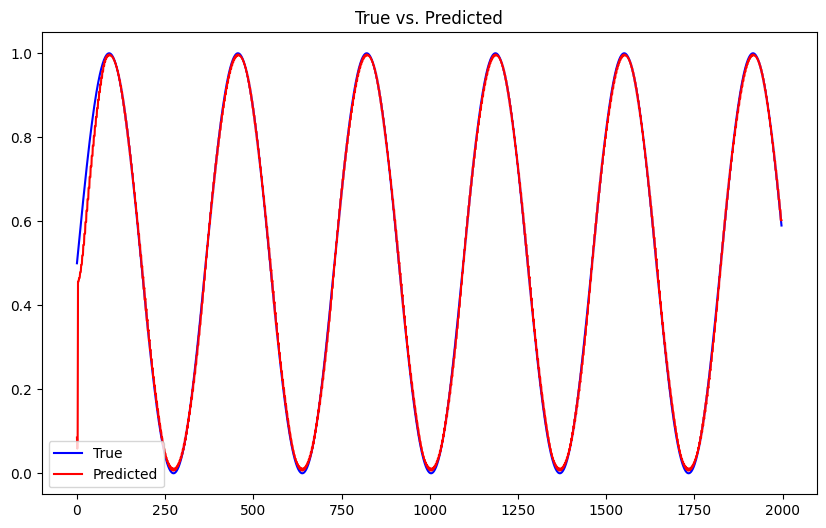

In [14]:
predicted_series, true_series = plot_with_predictions(model_sine, data_sine['temperature'])
plot_true_and_predicted(true_series, predicted_series)

In [15]:
predictor = Predictor(model_sine)
encoder = Encoder(predictor)
encoded_sine = encoder.encode(data_sine, 'temperature', threshold=0.05, residual_complete_switch_probability=0)

Encoding: 100%|██████████| 2000/2000 [00:43<00:00, 46.00it/s]


In [16]:
print(f"Encoded length: {len(encoded_sine)}")
print(f"Original length: {len(data_sine)}")
print(f"Compression ratio: {len(data_sine)/len(encoded_sine)}")

Encoded length: 742
Original length: 2000
Compression ratio: 2.6954177897574123


In [17]:
print(encoded_sine[0:5])
print(encoded_sine[0])

[<__main__.DataFrame object at 0x000001A87B640080>, <__main__.DataFrame object at 0x000001A859D294F0>, <__main__.DataFrame object at 0x000001A87B6402C0>, <__main__.DataFrame object at 0x000001A87B5B8980>, <__main__.DataFrame object at 0x000001A87B60E420>]
0|2024-11-17|False|0.4151852875947952|None


In [18]:
# Mean Squared Error (MSE)
mse = np.mean((true_series - predicted_series) ** 2)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(true_series - predicted_series))

# Mean of the true values
mean_true = np.mean(true_series)

# Total sum of squares (SST)
sst = np.sum((true_series - mean_true) ** 2)

# Residual sum of squares (SSE)
sse = np.sum((true_series - predicted_series) ** 2)

# R-squared
r2 = 1 - (sse / sst)

# Print the results
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f"R-squared: {r2}")

MSE: 0.0005977791038835859
RMSE: 0.02444952154713024
MAE: 0.009605223915270345
R-squared: 0.9952081527972183


In [19]:
def print_errors(true_series, predicted_series):
    # Mean Squared Error (MSE)
    mse = np.mean((true_series - predicted_series) ** 2)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(true_series - predicted_series))

    # Mean of the true values
    mean_true = np.mean(true_series)

    # Total sum of squares (SST)
    sst = np.sum((true_series - mean_true) ** 2)

    # Residual sum of squares (SSE)
    sse = np.sum((true_series - predicted_series) ** 2)

    # R-squared
    r2 = 1 - (sse / (sst + 1e-8))

    # Print the results
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f"R-squared: {r2}")

In [20]:
"""
    A single function,
        - to fit
        - to use it to encode
        - to get compression ratio
        - to get MSE, RMSE, MAE, R_squared
"""

def fit_encode_evaluate(dataframe, datacolumn="temperature", plot=False):
    # Fit
    model = KAN(width=[84,5,3], grid=5, k=3, seed=42, device=device)
    pretrain_timeseries_model(model, dataframe[datacolumn])

    # Predict
    predicted_series, true_series = plot_with_predictions(model, dataframe[datacolumn])

    # Encode
    predictor = Predictor(model)
    encoder = Encoder(predictor)
    encoded = encoder.encode(dataframe, datacolumn, 0.05, 0)

    # Evaluate
    print(f"Encoded length: {len(encoded)}")
    print(f"Original length: {len(dataframe)}")
    print(f"Compression ratio: {len(dataframe)/len(encoded)}")

    print_errors(true_series, predicted_series)

    # Plot
    if plot:
        plot_true_and_predicted(true_series, predicted_series)

checkpoint directory created: ./model
saving model version 0.0
torch.float32, torch.float32


| train_loss: 1.97e-02 | test_loss: 1.97e-02 | reg: 1.12e+01 | : 100%|█| 20/20 [00:37<00:00,  1.88s/


saving model version 0.1


Predicting:   0%|          | 0/666 [00:00<?, ?it/s]F:\Documents\UoJ\Semester 6\Research\KAN\pykan\kan\MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
F:\Documents\UoJ\Semester 6\Research\KAN\pykan\kan\MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
F:\Documents\UoJ\Semester 6\Research\KAN\pykan\kan\MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly les

Encoded length: 941
Original length: 2000
Compression ratio: 2.1253985122210413
MSE: 0.009226448726243635
RMSE: 0.0960544050330001
MAE: 0.01788204066219645
R-squared: 0.9776223187219983


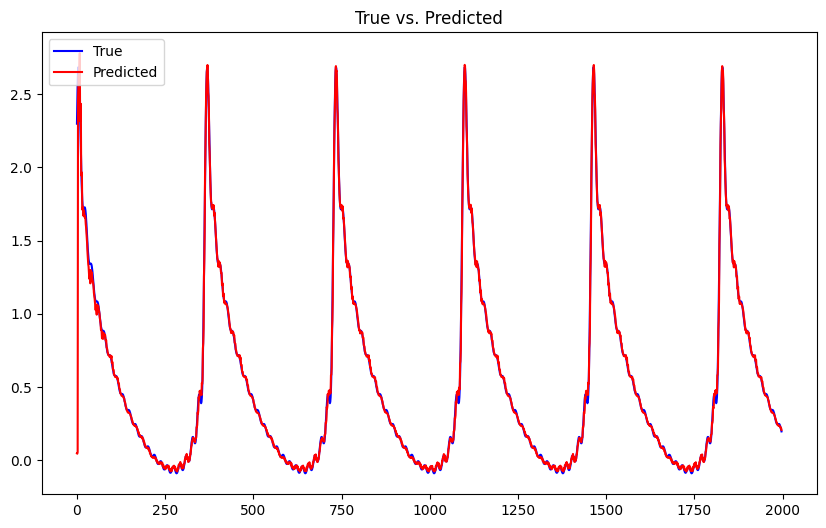

In [27]:
fit_encode_evaluate(data_complex_fourier, plot=True)

checkpoint directory created: ./model
saving model version 0.0
torch.float32, torch.float32


| train_loss: 2.40e-02 | test_loss: 2.40e-02 | reg: 5.63e+00 | : 100%|█| 20/20 [00:35<00:00,  1.79s/


saving model version 0.1


Predicting:   4%|▍         | 27/666 [00:01<00:39, 16.10it/s]C:\Users\atlee\AppData\Local\Temp\ipykernel_25292\3452047960.py:13: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  extracted_values = pd.concat([pd.Series(padding), extracted_values], ignore_index=True) if len(extracted_values) > 0 else pd.Series(padding)
Encoding: 100%|██████████| 2000/2000 [00:41<00:00, 47.79it/s]

Encoded length: 1030
Original length: 2000
Compression ratio: 1.941747572815534
MSE: 0.0009288156594855541
RMSE: 0.030476477150181813
MAE: 0.019744825352491367
R-squared: 0.9722568138795238


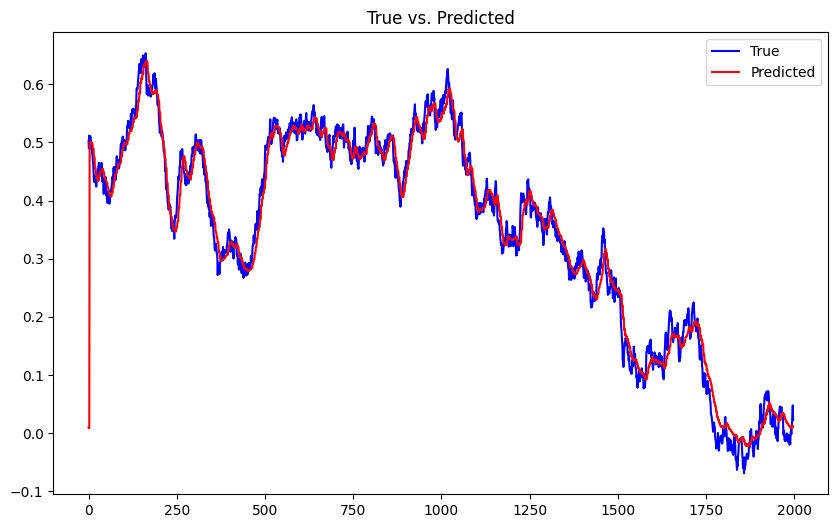

In [28]:
fit_encode_evaluate(data_random, plot=True)

checkpoint directory created: ./model
saving model version 0.0
torch.float32, torch.float32


| train_loss: 4.29e-02 | test_loss: 4.29e-02 | reg: 5.46e+00 | : 100%|█| 20/20 [00:37<00:00,  1.86s/


saving model version 0.1


Predicting:   4%|▍         | 28/666 [00:01<00:39, 16.33it/s]C:\Users\atlee\AppData\Local\Temp\ipykernel_25292\3452047960.py:13: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  extracted_values = pd.concat([pd.Series(padding), extracted_values], ignore_index=True) if len(extracted_values) > 0 else pd.Series(padding)
Encoding: 100%|██████████| 2000/2000 [00:40<00:00, 49.35it/s]


Encoded length: 283
Original length: 2000
Compression ratio: 7.067137809187279
MSE: 0.0021149435638522633
RMSE: 0.04598851556478273
MAE: 0.01626624849459795
R-squared: 0.8983313039174738


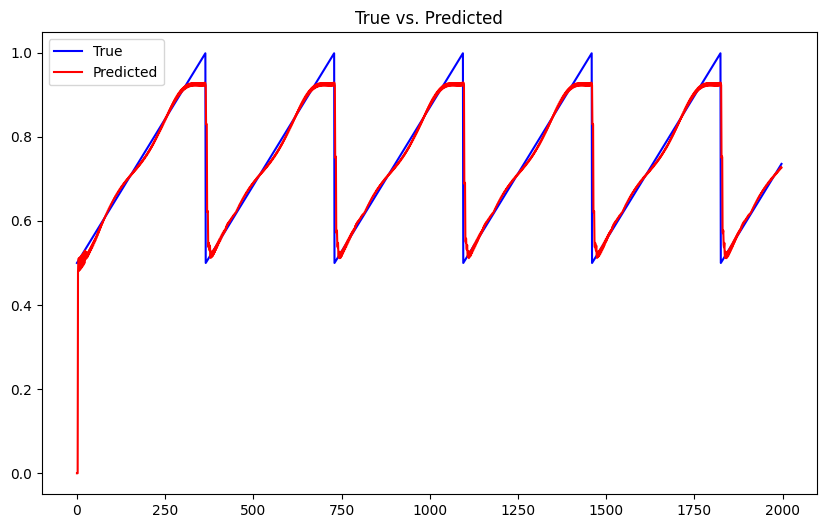

In [29]:
fit_encode_evaluate(data_sawtooth, plot=True)

checkpoint directory created: ./model
saving model version 0.0
torch.float32, torch.float32


| train_loss: 2.26e+00 | test_loss: 2.26e+00 | reg: 6.07e+01 | : 100%|█| 20/20 [00:06<00:00,  2.98it


saving model version 0.1


Predicting:  76%|███████▌  | 28/37 [00:01<00:00, 15.16it/s]C:\Users\atlee\AppData\Local\Temp\ipykernel_25292\3452047960.py:13: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  extracted_values = pd.concat([pd.Series(padding), extracted_values], ignore_index=True) if len(extracted_values) > 0 else pd.Series(padding)
Encoding:   0%|          | 0/114 [00:00<?, ?it/s]F:\Documents\UoJ\Semester 6\Research\KAN\pykan\kan\MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
F:\Documen

Encoded length: 91
Original length: 114
Compression ratio: 1.2527472527472527
MSE: 758.5407116900791
RMSE: 27.54161781177858
MAE: 20.957774137200946
R-squared: -1.151920368872085


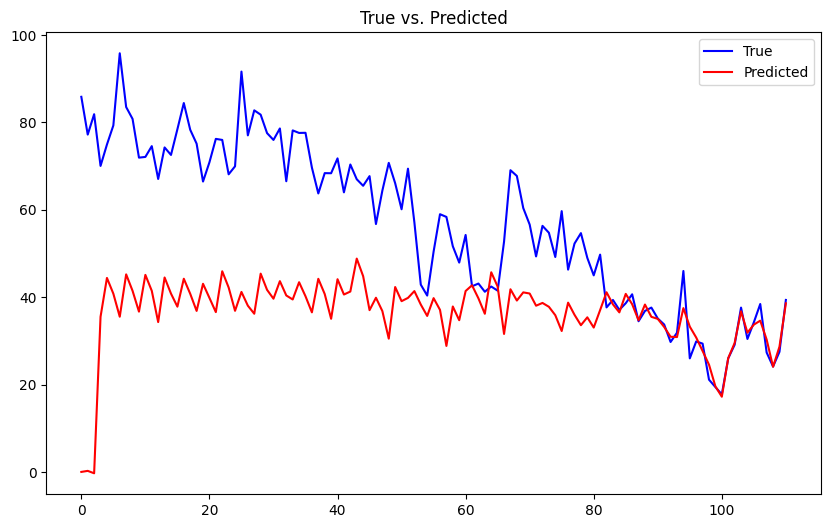

In [24]:
fit_encode_evaluate(df, 'humidity', True)

In [25]:
df_min_temp = pd.read_csv('daily-minimum-temperatures-in-me.csv')
df_min_temp.columns = ['timestamp', 'temperature']
df_min_temp['timestamp'] = pd.to_datetime(df_min_temp['timestamp'], format='%m/%d/%Y')

checkpoint directory created: ./model
saving model version 0.0
torch.float32, torch.float32


| train_loss: 2.60e+00 | test_loss: 2.60e+00 | reg: 4.58e+01 | : 100%|█| 20/20 [01:06<00:00,  3.31s/


saving model version 0.1


Predicting:   0%|          | 0/1216 [00:00<?, ?it/s]F:\Documents\UoJ\Semester 6\Research\KAN\pykan\kan\MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
F:\Documents\UoJ\Semester 6\Research\KAN\pykan\kan\MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
F:\Documents\UoJ\Semester 6\Research\KAN\pykan\kan\MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly le

Encoded length: 3008
Original length: 3650
Compression ratio: 1.2134308510638299
MSE: 7.05347856218821
RMSE: 2.6558385798440782
MAE: 2.0534833326216853
R-squared: 0.5745247294480321


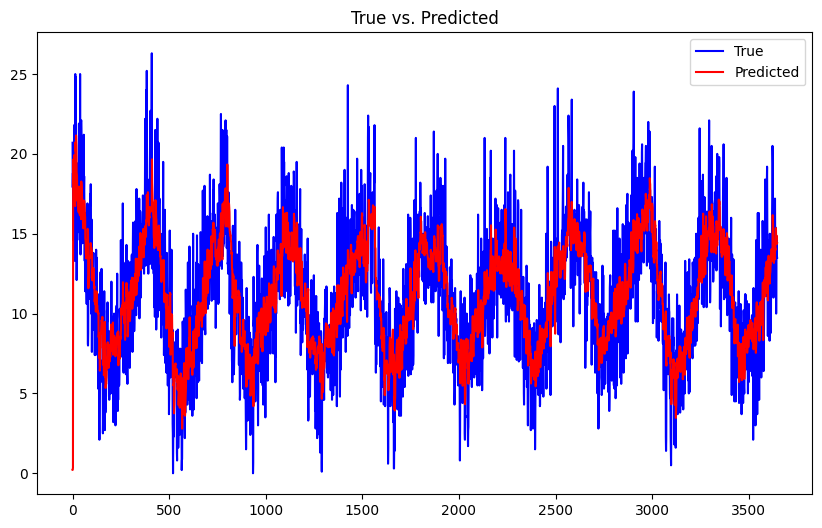

In [26]:
fit_encode_evaluate(df_min_temp, plot=True)

In [ ]:
csv_path = "ariviyalNagar.csv"  # Replace with your file path
column_1 = "Port 1"

# Load the data series
data_df = pd.read_csv(csv_path)
if column_1 not in data_df.columns:
    raise ValueError(f"Column '{column_1}' not found in the dataset!")

fit_encode_evaluate(data_df, column_1)

: 

In [ ]:
column_2 = "Port 1.4"

if column_2 not in data_df.columns:
    raise ValueError(f"Column '{column_2}' not found in the dataset!")

fit_encode_evaluate(data_df, column_1)

In [ ]:
column_3 = "Port 1.7"

if column_3 not in data_df.columns:
    raise ValueError(f"Column '{column_3}' not found in the dataset!")

fit_encode_evaluate(data_df, column_3)

In [ ]:
column_4 = "Port 2.1"

if column_4 not in data_df.columns:
    raise ValueError(f"Column '{column_4}' not found in the dataset!")

fit_encode_evaluate(data_df, column_4)